In [1]:
# Load packages and classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiffslide
import seaborn as sns
import gget
import tifffile
import zarr

# MosaicDataset and BruceDataset classes allow loading and visualisation of the different data sources
from gbmhackathon import MosaicDataset, BruceDataset

from sklearn.base import clone 

# models
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.linear_model import Ridge, RidgeCV, SGDRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.dummy import DummyRegressor

# cross validator
from sklearn.model_selection import (cross_validate, 
StratifiedShuffleSplit, ShuffleSplit, train_test_split)


# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile

# scoring
from sklearn.metrics import r2_score
from lifelines.utils import concordance_index

# permutation importance
from sklearn.inspection import permutation_importance


In [2]:
# extract the IDs where all modalities are available
filename_sample_table = "/home/ec2-user/SageMaker/data/mosaic_dataset/Data availibility per modality per patient.csv"
sample_table = pd.read_csv(filename_sample_table, index_col=0)
IDs = []
for index, row in sample_table.iterrows():
    if np.all(row=="Yes"):
        IDs.append(index)

In [3]:
# The following cell will returns a dictionary with the data sources in the
# keys and the list of files (and path) used to return the data.
source_dict_mosaic = MosaicDataset.load_tabular()

## Extract and preprocess clinical data

In [4]:
clin_df = source_dict_mosaic["clinical"]["processed gbm clinical"]
# Retrieve only samples with all omics available
not_all_omic_IDs=list(sample_table[sample_table.apply(lambda row: (row == 'No').any(), axis=1)].index)
clin_df_all_omics = clin_df[~clin_df.index.isin(not_all_omic_IDs)]
print("Retrieval shape:", clin_df_all_omics.shape)
clin_df_all_omics.head()
# Retrieve only most-useful clinical features
clin_df_all_omics_keep = clin_df_all_omics[["administrative_gender", "age_at_diagnosis_years","sample_collection_chronology", "os_years", "pfs_years", "largest_diameter_of_the_primary_tumour_mm_duplicated_0", "surgery_type"]] #removed os and pfs censor ?
clin_df_all_omics_keep.loc[:, 'os_years']= round(clin_df_all_omics_keep['os_years']*365,1)
clin_df_all_omics_keep.loc[:, 'pfs_years']= round(clin_df_all_omics_keep['pfs_years']*365,1)

clin_df_all_omics_keep = clin_df_all_omics_keep.rename(columns={"administrative_gender": "gender",
                                                                "age_at_diagnosis_years": "age",
                                                                "sample_collection_chronology": "time_point",
                                                                "os_years":"os_days",
                                                                "pfs_years":"pfs_days",
                                                                "largest_diameter_of_the_primary_tumour_mm_duplicated_0": "tumor_diameter"})
print("Resulting shape:",clin_df_all_omics_keep.shape)
clin_df_all_omics_keep.head()


Retrieval shape: (74, 40)
Resulting shape: (74, 7)


,gender,age,time_point,os_days,pfs_days,tumor_diameter,surgery_type
sample_id,,,,,,,
HK_G_001a,Male,65.465696,Baseline,543.6,543.6,42.0,Maximal safe resection
HK_G_002a,Male,37.077698,Baseline,883.4,621.6,46.0,Maximal safe resection
HK_G_003a,Female,54.503641,Baseline,638.6,341.8,NaN,Maximal safe resection
HK_G_004a,Female,52.702185,Baseline,425.7,94.9,29.0,Maximal safe resection
HK_G_005a,Male,57.660297,Baseline,1217.2,25.0,48.0,Maximal safe resection


In [5]:
# Preprocess
# convert cat variables to numerical with ordinal encoder, 

for col in ["gender", "time_point", "surgery_type"]:
    clin_df_all_omics_keep[col] = OrdinalEncoder().fit_transform(clin_df_all_omics_keep[[col]])
    
# and min-max scale the age
preproc = ColumnTransformer([("min_max_scaler", MinMaxScaler(), "age")], remainder='passthrough')

In [6]:
# Pipeline
clinical_pipeline = Pipeline(steps=[
                                    # ("preproc", preproc), 
                                    ("regressor", RidgeCV())
                                   ])

In [7]:
# drop all nans
clin_df_all_omics_keep = clin_df_all_omics_keep.dropna()

In [8]:
X = clin_df_all_omics_keep.drop(columns=["os_days"])
y = clin_df_all_omics_keep["os_days"]

scores = cross_validate(clinical_pipeline, X, y, error_score="raise")
scores

{'fit_time': array([0.00443697, 0.00311112, 0.00305867, 0.00301456, 0.00305223]),
 'score_time': array([0.00217748, 0.00212812, 0.00197005, 0.00197101, 0.00196576]),
 'test_score': array([-0.30875785,  0.36957143,  0.08195422, -0.02370397,  0.38397128])}

In [9]:
clinical_pipeline

Pipeline(steps=[('regressor', RidgeCV())])

## Fetch WES

In [8]:
wes_df = pd.read_csv("/home/ec2-user/SageMaker/gbm_hackathon/datafiles/WES_scores.csv",
                    index_col="sample id")
wes_df

,Glycolysis / Gluconeogenesis,PD-L1 expression and PD-1 checkpoint pathway in cancer,Chemical carcinogenesis - receptor activation,Chemical carcinogenesis - reactive oxygen species,Glioma,Chronic myeloid leukemia,Transcriptional misregulation in cancer,Viral carcinogenesis,Pathways of neurodegeneration - multiple diseases,Inflammatory mediator regulation of TRP channels,T cell receptor signaling pathway,B cell receptor signaling pathway,Fc epsilon RI signaling pathway,mTOR signaling pathway,PI3K-Akt signaling pathway,AMPK signaling pathway,JAK-STAT signaling pathway
sample id,,,,,,,,,,,,,,,,,
HK_G_001a,0.022739,2.707775,0.947258,2.353765,4.606135,2.812869,0.006440,2.331431,0.126232,2.678705,1.135384,1.245591,1.362624,3.673018,5.301459,2.641486,0.949612
HK_G_002a,0.006062,0.007785,0.014785,0.011872,1.811994,1.806309,0.001717,2.904220,0.033652,0.008057,0.009146,0.006969,0.005246,0.014056,1.159487,0.008420,0.014694
HK_G_003a,0.009094,1.581061,1.312122,1.403398,3.654384,1.633612,0.002576,2.728354,0.050481,0.012086,0.013720,0.010453,0.007870,1.333067,2.332127,0.012631,1.314681
HK_G_004a,0.007578,1.658318,3.157412,3.345716,3.828824,3.817310,0.002146,0.000678,0.042066,1.643699,3.570565,3.805948,4.052658,3.200716,2.500241,1.624969,3.162706
HK_G_005a,0.004546,1.876320,0.011088,1.695590,1.935258,0.005158,0.001288,0.000406,0.025238,0.006043,0.006860,0.005226,0.003935,1.623622,1.276426,0.006315,0.011020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_101a,0.006062,0.007785,0.014785,0.011872,0.006787,0.006878,2.404499,0.000542,0.033652,0.008057,0.009146,0.006969,0.005246,0.014056,0.032087,0.008420,0.014694
HK_G_111b,0.009094,1.581061,1.312122,1.403398,1.639251,3.642893,0.002576,0.000813,0.980868,0.012086,1.512940,1.628048,1.748958,1.333067,0.999396,0.012631,1.314681
HK_G_112a,0.006062,0.007785,0.014785,0.011872,1.811994,1.806309,0.001717,2.904220,0.033652,0.008057,0.009146,0.006969,0.005246,0.014056,1.159487,0.008420,0.014694


In [9]:
wes_model = Pipeline(steps=[("regressor", RidgeCV())])

In [12]:
### some feature importance on just wes
X_train, X_val, y_train, y_val = train_test_split(wes_df, 
                                    clin_df_all_omics_keep["os_days"],
                                    random_state=0)
wes_model_feat_imp = clone(wes_model)
wes_model_feat_imp.fit(X_train, y_train)
wes_model_feat_imp.score(X_val, y_val)

ValueError: Found input variables with inconsistent numbers of samples: [74, 63]

In [ ]:
r = permutation_importance(wes_model_feat_imp, X_val, y_val,
                           n_repeats=30,
                           random_state=0)


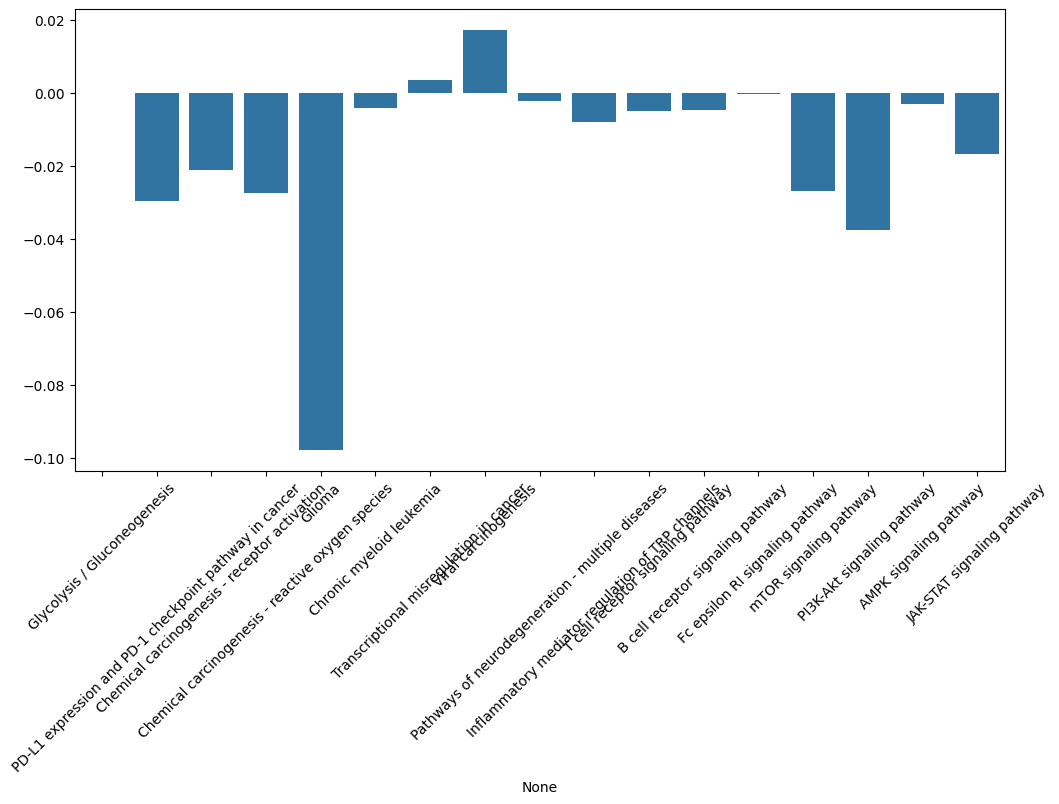

In [272]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(y=r["importances_mean"], x=wes_df.columns, ax=ax)
ax.tick_params(axis='x', labelrotation=45)

In [275]:
wes_df.columns[5]

'Chronic myeloid leukemia'

## Fetch bulk RNA seq

In [10]:
brna_df = pd.read_csv("/home/ec2-user/SageMaker/gbm_hackathon/datafiles/bRNA_topvargenes.csv", index_col="sample id")
brna_df = brna_df.T
brna_df

sample id,ENSG00000249092,ENSG00000204525,ENSG00000234745,ENSG00000230398,ENSG00000162599,ENSG00000102606,ENSG00000130066,ENSG00000253484,ENSG00000273786,ENSG00000254942,...,ENSG00000275516,ENSG00000166833,ENSG00000277586,ENSG00000166147,ENSG00000258104,ENSG00000162512,ENSG00000273650,ENSG00000166598,ENSG00000238169,ENSG00000224079
HK_G_001a_mRNA,4.703856,12.178583,12.907777,4.703856,14.224911,11.022080,12.653073,4.992128,4.304167,4.867634,...,4.304167,11.317797,7.409192,12.906917,4.304167,11.846859,4.304167,12.789619,4.304167,4.304167
HK_G_002a_mRNA,4.304167,12.235930,12.447251,4.304167,14.792357,12.315820,12.055883,4.802217,4.802217,4.912665,...,4.912665,12.063117,10.342404,10.029259,4.304167,12.765912,5.158565,12.509175,5.224864,5.005105
HK_G_003a_mRNA,5.656836,11.380349,11.529088,4.304167,15.228663,11.969173,11.418996,5.387515,4.304167,4.654000,...,4.304167,12.191043,4.654000,10.095917,5.078990,13.369558,4.304167,12.200019,4.654000,5.150972
HK_G_004a_mRNA,5.031741,12.256088,12.524305,4.821335,13.795770,11.475620,13.753107,4.304167,4.304167,4.304167,...,4.304167,12.746352,6.918381,11.719066,4.821335,13.220713,4.304167,12.929039,5.190717,5.115532
HK_G_005a_mRNA,4.935383,11.631151,12.099068,4.304167,14.422570,12.801186,11.068046,5.290845,5.074252,5.134362,...,5.008515,12.580023,7.007832,10.349101,5.134362,13.179696,4.304167,12.503328,4.304167,4.621658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_111b_mRNA,4.304167,12.363479,12.941311,5.390231,13.455806,11.697324,12.848940,4.304167,4.962912,4.722951,...,4.304167,11.455676,12.226365,11.567877,4.304167,11.878780,4.304167,13.355309,4.816181,4.304167
HK_G_112a_mRNA,4.304167,11.644778,12.604397,5.672948,14.747392,11.592035,10.094936,4.814597,4.892554,5.555808,...,4.814597,11.615587,6.911638,10.274521,5.078603,13.173299,4.304167,12.698516,4.304167,4.304167
HK_G_113b_mRNA,4.824609,10.678489,12.047358,5.594777,14.288842,11.572212,10.769376,4.824609,4.304167,4.304167,...,4.304167,11.286488,12.095702,9.885852,4.673167,12.187787,4.824609,12.448791,5.329019,4.304167
HK_G_114a_mRNA,4.304167,11.714034,12.820876,4.304167,15.031178,10.914036,13.734643,4.304167,4.791244,5.068979,...,4.304167,12.209109,6.110576,10.752309,4.304167,11.849069,5.140080,13.899416,4.304167,4.304167


In [11]:
brna_df.index = brna_df.index.str[:9]

In [12]:
brna_df = brna_df[brna_df.index.isin(IDs)]

In [13]:
brna_df

sample id,ENSG00000249092,ENSG00000204525,ENSG00000234745,ENSG00000230398,ENSG00000162599,ENSG00000102606,ENSG00000130066,ENSG00000253484,ENSG00000273786,ENSG00000254942,...,ENSG00000275516,ENSG00000166833,ENSG00000277586,ENSG00000166147,ENSG00000258104,ENSG00000162512,ENSG00000273650,ENSG00000166598,ENSG00000238169,ENSG00000224079
HK_G_001a,4.703856,12.178583,12.907777,4.703856,14.224911,11.022080,12.653073,4.992128,4.304167,4.867634,...,4.304167,11.317797,7.409192,12.906917,4.304167,11.846859,4.304167,12.789619,4.304167,4.304167
HK_G_002a,4.304167,12.235930,12.447251,4.304167,14.792357,12.315820,12.055883,4.802217,4.802217,4.912665,...,4.912665,12.063117,10.342404,10.029259,4.304167,12.765912,5.158565,12.509175,5.224864,5.005105
HK_G_003a,5.656836,11.380349,11.529088,4.304167,15.228663,11.969173,11.418996,5.387515,4.304167,4.654000,...,4.304167,12.191043,4.654000,10.095917,5.078990,13.369558,4.304167,12.200019,4.654000,5.150972
HK_G_004a,5.031741,12.256088,12.524305,4.821335,13.795770,11.475620,13.753107,4.304167,4.304167,4.304167,...,4.304167,12.746352,6.918381,11.719066,4.821335,13.220713,4.304167,12.929039,5.190717,5.115532
HK_G_005a,4.935383,11.631151,12.099068,4.304167,14.422570,12.801186,11.068046,5.290845,5.074252,5.134362,...,5.008515,12.580023,7.007832,10.349101,5.134362,13.179696,4.304167,12.503328,4.304167,4.621658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_101a,4.304167,11.202098,11.965252,5.037668,14.428520,11.717771,11.419408,4.304167,4.304167,4.304167,...,4.874747,12.167621,11.526889,10.197864,4.304167,12.539923,5.378859,12.742653,5.280176,4.304167
HK_G_111b,4.304167,12.363479,12.941311,5.390231,13.455806,11.697324,12.848940,4.304167,4.962912,4.722951,...,4.304167,11.455676,12.226365,11.567877,4.304167,11.878780,4.304167,13.355309,4.816181,4.304167
HK_G_112a,4.304167,11.644778,12.604397,5.672948,14.747392,11.592035,10.094936,4.814597,4.892554,5.555808,...,4.814597,11.615587,6.911638,10.274521,5.078603,13.173299,4.304167,12.698516,4.304167,4.304167
HK_G_114a,4.304167,11.714034,12.820876,4.304167,15.031178,10.914036,13.734643,4.304167,4.791244,5.068979,...,4.304167,12.209109,6.110576,10.752309,4.304167,11.849069,5.140080,13.899416,4.304167,4.304167


In [14]:
brna_model = Pipeline(steps=[("regressor", RidgeCV())])

## Fetch Spatial transcriptomics

In [15]:
spatial_df = pd.read_csv("/home/ec2-user/SageMaker/gbm_hackathon/datafiles/top_500_ST.csv", index_col="sample id")
spatial_df = spatial_df.dropna(axis=0)
spatial_df.index = spatial_df.index.str[:-4]
spatial_df = spatial_df[spatial_df.index.isin(IDs)]
spatial_df

,AGRN,SDF4,ACAP3,CCNL2,GNB1,SKI,RER1,LRRC47,RERE,CLSTN1,...,GPR137B,SDCCAG8,AKT3,SCCPDH,ADI1,ID2,KIDINS220,MBOAT2,YWHAQ,PDIA6
sample id,,,,,,,,,,,,,,,,,,,,,
HK_G_002a,4.570274,5.080049,4.309626,6.277286,5.393930,5.058819,4.593429,4.825311,4.583151,5.555645,...,5.447338,4.033937,5.377802,4.485143,5.065335,5.668485,4.601218,5.317588,4.970755,4.505578
HK_G_003a,3.922937,4.651763,4.065282,6.322796,4.551888,4.713501,3.987335,4.136594,4.269559,5.245800,...,4.480180,3.519556,4.874005,3.700953,3.529164,4.521650,3.579890,3.939753,4.178493,3.680404
HK_G_004a,2.347162,5.006238,1.711660,6.018440,4.312255,4.499727,3.257296,2.864637,1.943117,3.113482,...,3.386649,2.682745,1.686842,2.409933,4.039726,4.462206,2.468908,1.982246,2.931891,4.266317
HK_G_005a,4.646352,4.174127,5.135867,5.912312,4.618717,4.612394,3.599957,3.725495,4.171392,5.058570,...,4.065565,3.909264,4.868150,4.296804,3.184740,5.210342,3.936668,3.889391,4.332670,3.350684
HK_G_006a,1.405587,3.257102,1.730065,4.465287,3.519635,2.653008,2.209687,2.390109,2.414746,3.379322,...,2.193440,1.931056,3.600747,1.707507,2.671823,3.623529,2.228294,2.280517,2.835338,2.371407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_101a,1.071067,2.255625,1.405772,4.479338,2.356728,1.798825,2.141779,1.316772,1.694300,1.453552,...,1.091712,1.408856,2.197999,1.910559,1.605258,3.134480,1.018940,2.884795,1.729310,0.837086
HK_G_111b,0.995065,2.184286,0.748478,2.771845,2.318091,1.567512,1.421661,0.991147,1.337886,1.284335,...,1.045448,0.856826,1.319531,1.156069,0.981541,1.327780,0.467705,0.703201,1.472458,1.121407
HK_G_112a,0.885545,1.477734,1.023140,3.528546,2.551279,1.241986,1.232327,1.067419,2.910982,2.270590,...,2.237483,2.283356,4.386835,2.971341,1.268681,5.352007,1.714814,2.597879,3.549404,1.758595


In [16]:
spatial_model = Pipeline(steps=[("regressor", RidgeCV())])

## Fetch single cell rna seq

In [17]:
single_df = pd.read_csv("/home/ec2-user/SageMaker/gbm_hackathon/datafiles/RNAseq.csv", index_col="sample id")
single_df = single_df.drop(columns=["os_days"])
single_df = single_df[single_df.index.isin(IDs)]

In [18]:
single_model = Pipeline(steps=[("regressor", RidgeCV())])

## Extracting HE1 embeddings:
First we average all the tile-wise embeddings for each slide
and then use these embeddings to predict different variables

In [153]:
he_emb = source_dict_mosaic["he"]["H1 features"][source_dict_mosaic["he"]["H1 features"].index.isin(IDs)]
he_emb

,path,patient id
Subject Id,,
HK_G_001a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_001
HK_G_002a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_002
HK_G_003a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_003
HK_G_004a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_004
HK_G_005a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_005
...,...,...
HK_G_101a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_101
HK_G_111b,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_111
HK_G_112a,/home/ec2-user/SageMaker/data/h1_bioptimus_fea...,HK_G_112


In [46]:
N_slides = len(he_emb)

av_he_emb_per_slide = []

for i in range(N_slides):
    tmp = zarr.open(he_emb.path.values[i], mode='r')
    tmp = tmp["emb"][:]
    mean_tmp = np.mean(tmp, axis=0)
    av_he_emb_per_slide.append(mean_tmp)

In [119]:
av_h1_df = pd.DataFrame(av_he_emb_per_slide)
av_h1_df.index = he_emb.index
av_h1_df

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
Subject Id,,,,,,,,,,,,,,,,,,,,,
HK_G_001a,0.370166,-0.188180,0.692507,0.563786,0.100556,-0.145531,0.052874,0.721242,-0.291312,-0.419615,...,-0.305701,0.241915,0.091313,-0.238211,0.514571,0.689155,0.427871,-0.138591,-0.162799,0.362157
HK_G_002a,-0.601958,-0.128040,0.423638,-0.288386,0.335864,-0.321566,-1.099804,0.512392,-0.826215,-0.086351,...,-0.703194,-0.096536,-0.611808,-0.243279,-0.186056,1.033466,0.251726,-0.472446,-0.011373,0.198118
HK_G_003a,0.028916,-0.094420,0.336232,-0.364947,-0.111807,-0.164053,-0.432208,0.652939,-0.486923,-0.135070,...,-0.467926,0.255225,-0.226732,-0.228814,0.167838,1.387018,0.585169,0.142253,0.023361,0.507096
HK_G_004a,-0.098684,-0.016353,0.490221,-0.110518,-0.149697,-0.374470,-1.076777,0.552333,-0.320579,-0.036995,...,-0.422414,0.563004,-0.010502,-0.182116,0.369120,0.969986,-0.174840,0.285319,-0.288556,-0.036669
HK_G_005a,-0.090653,0.054576,0.241105,-0.060307,-0.227351,-0.717685,-0.299450,0.918888,-0.692417,0.468453,...,-0.662239,0.418213,0.032993,-0.222866,0.102107,1.126148,-0.271324,0.309909,-0.777260,0.265822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_101a,-0.523158,0.241655,0.128916,-0.410165,-0.286785,0.236259,-0.624554,0.668134,0.212051,-0.053636,...,-0.682926,-0.181893,-0.456288,0.003729,0.682185,0.319976,0.384064,-0.038450,0.165323,0.023934
HK_G_111b,-0.660406,-0.290955,0.383776,-0.417440,-0.419608,0.180252,-0.462201,0.180471,0.117107,0.072134,...,-0.585373,-0.200424,-0.230068,0.042415,0.657781,0.221070,0.330174,-0.097667,0.489333,-0.149260
HK_G_112a,-0.874065,-0.161503,-0.043573,-0.442004,-0.831809,0.212076,-0.721190,0.329392,-0.247877,0.163318,...,-0.576092,-0.544561,-0.530727,0.080136,0.371567,0.285371,0.278682,-0.243657,0.425138,-0.203711


In [121]:
h1_pipeline = Pipeline(steps=[("regressor", LinearSVR())])

## Make sure there are no NaNs

In [19]:
wes_df = wes_df[wes_df.index.isin(list(clin_df_all_omics_keep.index))]
spatial_df = spatial_df[spatial_df.index.isin(list(clin_df_all_omics_keep.index))]
wes_df = wes_df[wes_df.index.isin(list(spatial_df.index))]
clin_df_all_omics_keep = clin_df_all_omics_keep[clin_df_all_omics_keep.index.isin(list(spatial_df.index))]
single_df = single_df[single_df.index.isin(list(clin_df_all_omics_keep.index))]

In [20]:
len(wes_df), len(spatial_df), len(clin_df_all_omics_keep), len(single_df)

(61, 61, 61, 61)

In [21]:
len(wes_df.columns) + len(spatial_df.columns) + len(clin_df_all_omics_keep.columns) + len(single_df.columns)

1117

## Stack the regressors

In [99]:
clinical_X = clin_df_all_omics_keep.drop(columns=["os_days"])
stacked_X = pd.concat([
                        clinical_X, 
                        wes_df,
                        brna_df,
                        spatial_df,
                        single_df,
                      ], axis=1)

stacked_X = stacked_X.drop(columns=list(stacked_X.columns.value_counts().index[:3]))
stacked_X = stacked_X.dropna()
feature_selector = SelectPercentile(f_classif, percentile=40)

y = clin_df_all_omics_keep["os_days"]

cv = ShuffleSplit(random_state=50)
dummy = DummyRegressor()

scores = {"c_index": {"dummy":[], "stacked":[]}, "r2": {"dummy":[], "stacked":[]}}
predicted_os = []
true_os = []
dummy_predicted_os = []
for idx, (train, test) in enumerate(cv.split(np.zeros(len(y)), y)):
    train, test = stacked_X.index[train], stacked_X.index[test]

    selected_features_vals = feature_selector.fit_transform(stacked_X.loc[train], y.loc[train])
    selected_features_names = feature_selector.get_feature_names_out(input_features=list(stacked_X.columns))

    clinical_selected_features = list(set(clinical_X.columns) & set(selected_features_names))
    wes_selected_features = list(set(wes_df.columns) & set(selected_features_names))
    brna_selected_features = list(set(brna_df.columns) & set(selected_features_names))
    spatial_selected_features = list(set(spatial_df.columns) & set(selected_features_names))
    single_selected_features = list(set(single_df.columns) & set(selected_features_names))
    
    pipe_clinical = Pipeline([
    ('select', ColumnTransformer([('sel', 'passthrough', clinical_selected_features)], remainder='drop')), 
    ('clf', clinical_pipeline)
])
    pipe_wes = Pipeline([
        ('select', ColumnTransformer([('sel', 'passthrough', wes_selected_features)], remainder='drop')),
        ('clf', wes_model)
    ])
    pipe_brna = Pipeline([
        ('select', ColumnTransformer([('sel', 'passthrough', brna_selected_features)], remainder='drop')),
        ('clf', brna_model)
    ])
    pipe_spatial = Pipeline([
        ('select', ColumnTransformer([('sel', 'passthrough', spatial_selected_features)], remainder='drop')),
        ('clf', spatial_model)
    ])
    pipe_single = Pipeline([
        ('select', ColumnTransformer([('sel', 'passthrough', single_selected_features)], remainder='drop')),
        ('clf', single_model)
    ])
    
    stacker = StackingRegressor(estimators=[
                                            ("clinical", pipe_clinical),
                                            ("wes", pipe_wes),
                                            ("brna", pipe_brna),
                                            ("spatial", pipe_spatial),
                                            ("single", pipe_single)
                                           ],
                                final_estimator=RidgeCV())

    
    X_train = stacked_X.loc[train, selected_features_names]
    X_test = stacked_X.loc[test, selected_features_names] 

    stacker.fit(X_train, y.loc[train])
    
    prediction = stacker.predict(X_test)
    predicted_os.append(np.array(prediction))

    true_os.append(np.array(y.loc[test]))

    dummy.fit(X_train, y.loc[train])

    dummy_prediction = dummy.predict(X_test)
    dummy_predicted_os.append(np.array(dummy_prediction))

    
    r2 = r2_score(y.loc[test], prediction)
    dummy_r2 = r2_score(y.loc[test], dummy_prediction)
    scores["r2"]["stacked"].append(r2)
    scores["r2"]["dummy"].append(dummy_r2)
    print(f"R2 CV split - {idx}: {r2} | {dummy_r2}")
    
    c_index = concordance_index(y.loc[test], prediction)
    dummy_c = concordance_index(y.loc[test], dummy_prediction)
    scores["c_index"]["stacked"].append(c_index)
    scores["c_index"]["dummy"].append(dummy_c)
    print(f"C-index CV split - {idx}: {c_index} | {dummy_c}")
    

print(f"Mean R2:  {np.mean(np.array(scores['r2']['stacked']))} | {np.mean(np.array(scores['r2']['dummy']))}")
print(f"Mean C-index: {np.mean(np.array(scores['c_index']['stacked']))} | {np.mean(np.array(scores['c_index']['dummy']))}")

/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 0: 0.7244922516165235 | -0.04060842289515909
C-index CV split - 0: 0.8 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 1: 0.30161515248554915 | -0.07611339358055891
C-index CV split - 1: 0.8571428571428571 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 2: 0.4092216138074337 | -0.023187933534165817
C-index CV split - 2: 0.7619047619047619 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 3: 0.672207473167943 | -0.008511638143585687
C-index CV split - 3: 0.7619047619047619 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 4: 0.32633376414811877 | -0.003063341820420895
C-index CV split - 4: 0.7619047619047619 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 5: -0.8412054935711313 | -0.7444554123503728
C-index CV split - 5: 0.5238095238095238 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 6: 0.3560087599548012 | -0.09443994133415035
C-index CV split - 6: 0.47619047619047616 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 7: 0.17017374244285288 | -0.1742760307328317
C-index CV split - 7: 0.6666666666666666 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 8: 0.38662101904496904 | -0.02215801499886494
C-index CV split - 8: 0.7142857142857143 | 0.5


/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ec2-user/SageMaker/.conda/envs/gbmhackathon/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


R2 CV split - 9: 0.20845840299019236 | -0.265828838904558
C-index CV split - 9: 0.55 | 0.5
Mean R2:  0.27139266860872524 | -0.14526429682946682
Mean C-index: 0.6873809523809523 | 0.5


In [100]:
scores

{'c_index': {'dummy': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  'stacked': [0.8,
   0.8571428571428571,
   0.7619047619047619,
   0.7619047619047619,
   0.7619047619047619,
   0.5238095238095238,
   0.47619047619047616,
   0.6666666666666666,
   0.7142857142857143,
   0.55]},
 'r2': {'dummy': [-0.04060842289515909,
   -0.07611339358055891,
   -0.023187933534165817,
   -0.008511638143585687,
   -0.003063341820420895,
   -0.7444554123503728,
   -0.09443994133415035,
   -0.1742760307328317,
   -0.02215801499886494,
   -0.265828838904558],
  'stacked': [0.7244922516165235,
   0.30161515248554915,
   0.4092216138074337,
   0.672207473167943,
   0.32633376414811877,
   -0.8412054935711313,
   0.3560087599548012,
   0.17017374244285288,
   0.38662101904496904,
   0.20845840299019236]}}

In [101]:
scores_df = pd.DataFrame(scores)
scores_df

,c_index,r2
dummy,"[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[-0.04060842289515909, -0.07611339358055891, -..."
stacked,"[0.8, 0.8571428571428571, 0.7619047619047619, ...","[0.7244922516165235, 0.30161515248554915, 0.40..."


In [102]:
scores_df = scores_df.explode(["c_index", "r2"])

In [103]:
scores_df = scores_df.reset_index()

In [104]:
scores_df = scores_df.rename(columns={"index":"model"})

<Axes: ylabel='c_index'>

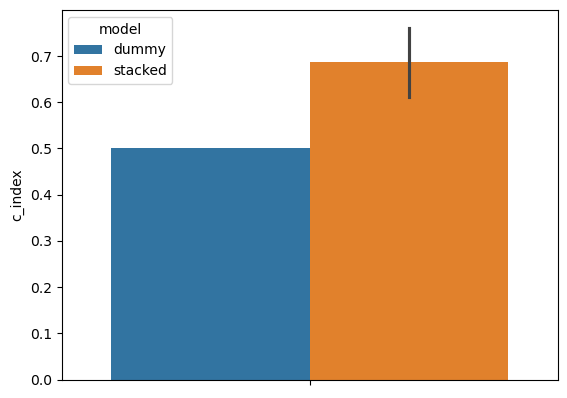

In [105]:
sns.barplot(scores_df, y="c_index", hue="model")

/tmp/ipykernel_8639/2437827454.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_combined,


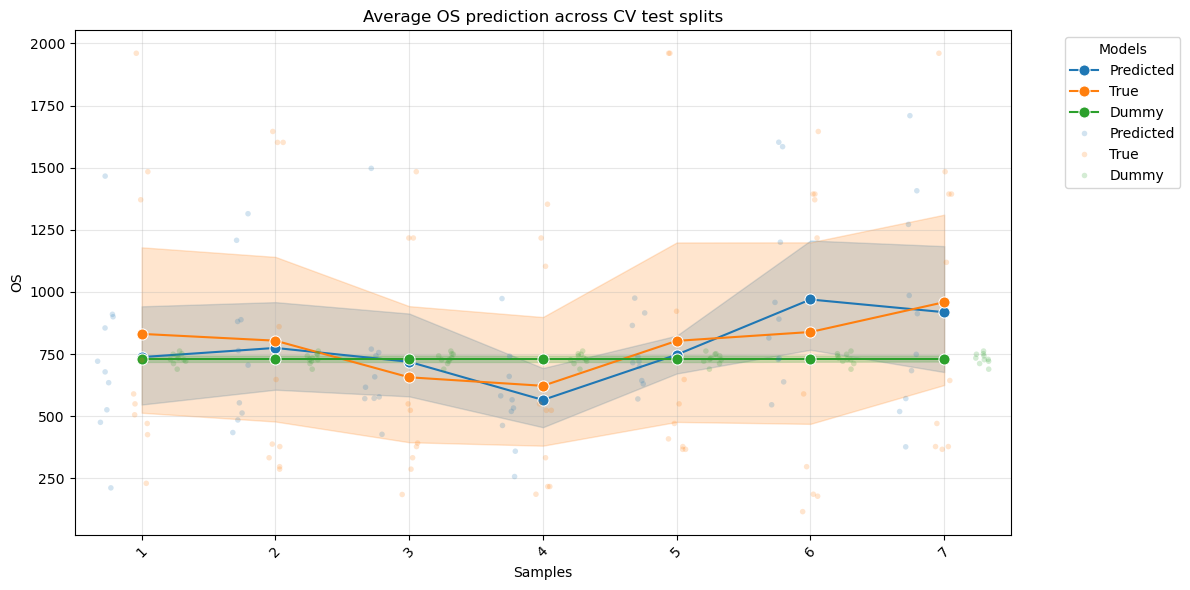


Predicted Statistics:
Mean: [737.84 774.73 718.94 565.39 747.36 969.66 918.6 ]
Std: [334.27 302.97 293.19 199.44 131.04 375.08 428.44]
95% CI:
T1: [270.88, 1341.10]
T2: [445.57, 1290.84]
T3: [459.37, 1333.81]
T4: [280.03, 921.14]
T5: [583.02, 961.86]
T6: [566.68, 1598.62]
T7: [408.70, 1641.46]

True Statistics:
Mean: [831.24 803.95 656.55 622.28 803.15 838.83 958.83]
Std: [568.06 587.99 465.99 440.58 633.39 617.88 581.92]
95% CI:
T1: [273.88, 1853.44]
T2: [289.05, 1636.00]
T3: [207.83, 1423.97]
T4: [192.88, 1322.52]
T5: [366.70, 1960.70]
T6: [129.85, 1589.22]
T7: [369.18, 1853.44]

Dummy Statistics:
Mean: [731.84 731.84 731.84 731.84 731.84 731.84 731.84]
Std: [21.34 21.34 21.34 21.34 21.34 21.34 21.34]
95% CI:
T1: [694.30, 759.76]
T2: [694.30, 759.76]
T3: [694.30, 759.76]
T4: [694.30, 759.76]
T5: [694.30, 759.76]
T6: [694.30, 759.76]
T7: [694.30, 759.76]


In [111]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_confidence_sns(data_dict, title="Comparison with Confidence Intervals"):
    """
    Plot multiple datasets with confidence intervals using seaborn
    
    Parameters:
    data_dict: Dictionary of arrays {name: 2D_array}
        Example: {'Model1': array1, 'Model2': array2, ...}
    """
    # Create DataFrame for all data
    dfs = []
    for name, data in data_dict.items():
        df = pd.DataFrame(data)
        df.columns = [f'{i+1}' for i in range(data.shape[1])]
        df_melted = df.melt(var_name='Timepoint', value_name='Value')
        df_melted['Model'] = name
        dfs.append(df_melted)
    
    # Combine all data
    df_combined = pd.concat(dfs, axis=0)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot lines with confidence intervals
    sns.lineplot(data=df_combined,
                x='Timepoint',
                y='Value',
                hue='Model',
                ci=95,
                err_style='band',
                marker='o',
                markersize=8)
    
    # Add individual points with jitter (optional)
    sns.stripplot(data=df_combined,
                 x='Timepoint',
                 y='Value',
                 hue='Model',
                 size=4,
                 alpha=0.2,
                 jitter=0.2,
                 dodge=True)
    
    # Customize the plot
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('OS')
    plt.grid(True, alpha=0.3)
    
    # Adjust legend
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Calculate and print statistics
    stats = {}
    for name, data in data_dict.items():
        df = pd.DataFrame(data)
        stats[name] = {
            'mean': df.mean().values,
            'std': df.std().values,
            'ci95': [np.percentile(data[:, i], [2.5, 97.5]) for i in range(data.shape[1])]
        }
    
    return df_combined, stats

# Example usage with multiple inputs
data_dict = {
    'Predicted': predicted_os,  # Your first 2D array
    'True': true_os,  # Your second 2D array
    'Dummy': dummy_predicted_os  # Optional third array, etc.
}

# Create the plot
df_combined, stats = plot_multiple_confidence_sns(data_dict, 
                                                title="Average OS prediction across CV test splits")

# Print statistics for each model
for model, stat in stats.items():
    print(f"\n{model} Statistics:")
    print(f"Mean: {stat['mean'].round(2)}")
    print(f"Std: {stat['std'].round(2)}")
    print("95% CI:")
    for i, ci in enumerate(stat['ci95']):
        print(f"T{i+1}: [{ci[0]:.2f}, {ci[1]:.2f}]")

In [106]:
predicted_os = np.array(predicted_os)
true_os = np.array(true_os)
dummy_predicted_os = np.array(dummy_predicted_os)

In [107]:
np.array(predicted_os).mean(axis=0).shape

(7,)

<Axes: >

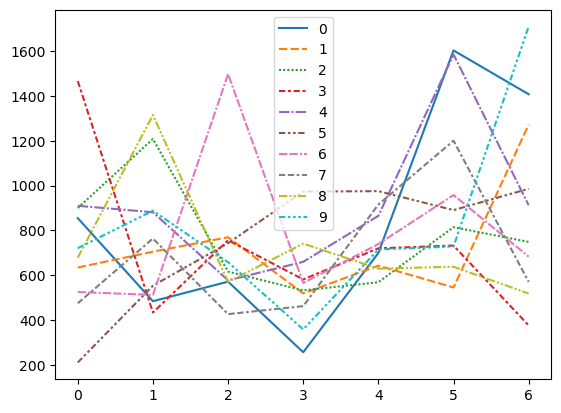

In [108]:
sns.lineplot(predicted_os.T,
             estimator=np.mean, 
             err_style="band", 
             errorbar ='sd',)


In [109]:
np.arange(predicted_os.shape[1])

array([0, 1, 2, 3, 4, 5, 6])

In [110]:
predicted_os

array([[ 855.08428431,  484.69644351,  571.8760251 ,  257.09172737,
         699.82394282, 1602.64862596, 1407.27131411],
       [ 634.8327248 ,  705.37762496,  769.95741532,  519.35189686,
         643.18848599,  545.93725634, 1271.95678054],
       [ 900.10537287, 1207.91656646,  616.56356465,  532.92377116,
         569.38507805,  814.77401685,  749.00761348],
       [1466.23682823,  434.20595601,  756.27090073,  581.88405965,
         720.45312177,  732.70825476,  376.72493494],
       [ 910.07777926,  881.14810156,  577.68189681,  660.22855424,
         865.25217709, 1584.72251528,  912.6299993 ],
       [ 211.52399594,  553.74029186,  743.33655722,  973.35501643,
         975.27962574,  890.82366452,  985.8725115 ],
       [ 525.72193922,  512.77544973, 1497.51012059,  566.01407624,
         739.3044221 ,  958.0012908 ,  683.27857765],
       [ 475.32135366,  764.17545988,  427.03023315,  462.6928542 ,
         915.63019596, 1200.24461886,  570.99948249],
       [ 678.33450226, 1

In [95]:
stacked_X

,gender,age,time_point,pfs_days,tumor_diameter,surgery_type,Glycolysis / Gluconeogenesis,PD-L1 expression and PD-1 checkpoint pathway in cancer,Chemical carcinogenesis - receptor activation,Chemical carcinogenesis - reactive oxygen species,...,AVPR1B,GPM6A,IMPG1,TMEM202,NRG2,RTKN2,GDF9,ZAR1L,PLPPR5,ZNF433
HK_G_002a,1.0,37.077698,1.0,621.6,46.0,0.0,0.006062,0.007785,0.014785,0.011872,...,4.158883,7870.141397,0.0,0.0,351.349619,403.277890,63.429743,4.158883,621.955555,294.274856
HK_G_004a,0.0,52.702185,1.0,94.9,29.0,0.0,0.007578,1.658318,3.157412,3.345716,...,0.000000,2344.478953,0.0,0.0,74.520097,27.673771,6.238325,0.000000,79.607694,95.602195
HK_G_005a,1.0,57.660297,1.0,25.0,48.0,0.0,0.004546,1.876320,0.011088,1.695590,...,0.000000,9259.927636,0.0,0.0,462.501157,557.961743,43.903838,7.049255,1022.536461,452.876314
HK_G_006a,1.0,75.603680,1.0,177.9,53.0,0.0,0.003031,0.003892,0.007392,0.005936,...,0.000000,2806.898368,0.0,0.0,80.183058,206.000561,12.476649,0.000000,230.676343,74.572213
HK_G_007a,0.0,71.299896,1.0,353.8,40.0,0.0,0.003031,0.003892,0.007392,0.005936,...,0.000000,3431.972583,0.0,0.0,191.492072,119.248417,8.723231,0.000000,319.281399,138.695103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_041a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HK_G_050a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HK_G_052a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HK_G_053a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
stacked_X.dropna()

,gender,age,time_point,pfs_days,tumor_diameter,surgery_type,Glycolysis / Gluconeogenesis,PD-L1 expression and PD-1 checkpoint pathway in cancer,Chemical carcinogenesis - receptor activation,Chemical carcinogenesis - reactive oxygen species,...,AVPR1B,GPM6A,IMPG1,TMEM202,NRG2,RTKN2,GDF9,ZAR1L,PLPPR5,ZNF433
HK_G_002a,1.0,37.077698,1.0,621.6,46.0,0.0,0.006062,0.007785,0.014785,0.011872,...,4.158883,7870.141397,0.0,0.0,351.349619,403.277890,63.429743,4.158883,621.955555,294.274856
HK_G_004a,0.0,52.702185,1.0,94.9,29.0,0.0,0.007578,1.658318,3.157412,3.345716,...,0.000000,2344.478953,0.0,0.0,74.520097,27.673771,6.238325,0.000000,79.607694,95.602195
HK_G_005a,1.0,57.660297,1.0,25.0,48.0,0.0,0.004546,1.876320,0.011088,1.695590,...,0.000000,9259.927636,0.0,0.0,462.501157,557.961743,43.903838,7.049255,1022.536461,452.876314
HK_G_006a,1.0,75.603680,1.0,177.9,53.0,0.0,0.003031,0.003892,0.007392,0.005936,...,0.000000,2806.898368,0.0,0.0,80.183058,206.000561,12.476649,0.000000,230.676343,74.572213
HK_G_007a,0.0,71.299896,1.0,353.8,40.0,0.0,0.003031,0.003892,0.007392,0.005936,...,0.000000,3431.972583,0.0,0.0,191.492072,119.248417,8.723231,0.000000,319.281399,138.695103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HK_G_101a,0.0,67.543668,1.0,551.6,42.0,0.0,0.006062,0.007785,0.014785,0.011872,...,0.000000,2996.011873,0.0,0.0,136.223748,88.672980,65.914649,2.772589,291.228136,215.138294
HK_G_111b,1.0,69.419044,0.0,244.8,25.0,0.0,0.009094,1.581061,1.312122,1.403398,...,0.000000,283.657567,0.0,0.0,15.367021,20.649590,6.238325,0.000000,12.999897,22.821741
HK_G_112a,0.0,54.736352,1.0,799.5,38.0,0.0,0.006062,0.007785,0.014785,0.011872,...,6.931472,7463.770495,0.0,0.0,194.672383,437.189146,88.213142,0.000000,63.900875,384.739595
HK_G_114a,1.0,48.253299,1.0,1015.3,40.0,0.0,0.004546,0.005839,0.011088,0.008904,...,0.000000,352.195780,0.0,0.0,40.843568,16.871098,7.624619,0.000000,3.871201,30.210794
